In [1]:
import sys
sys.path.append('/vol/tensusers4/nhollain/thesis2023-2024/s_clip_scripts')

from s_clip_scripts.data_loader import get_data, get_custom_data, TokenizedDataset, create_datainfo
from s_clip_scripts.tools import read_json, write_json
from collections import Counter
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /home/nhollain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nhollain/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
print(os.listdir('./data'))

print(os.listdir('./data/AID'))
print(os.listdir('./data/RSSCN7'))
print(os.listdir('./data/WHU-RS19'))
print(os.listdir('./data/NWPU-RESISC45'))
# print(os.listdir('./data/AID/Airport'))

['sydney_captions', 'UCMerced_LandUse', 'WHU-RS19', 'RSSCN7', 'AID', 'NWPU-RESISC45', 'RSICD', 'UCM', 'polyvore_outfits.zip', 'fashion200k', 'fashiongen', 'UCMerced_LandUse.zip', 'polyvore_outfits']
['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
['README.md', 'aGrass', 'bField', 'cIndustry', 'dRiverLake', 'eForest', 'fResident', 'gParking']
['Airport', 'Beach', 'Bridge', 'Commercial', 'Desert', 'Farmland', 'footballField', 'Forest', 'Industrial', 'Meadow', 'Mountain', 'Park', 'Parking', 'Pond', 'Port', 'railwayStation', 'Residential', 'River', 'Viaduct']
['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_fa

In [3]:
def get_files_RS_CLS(rs_cls_folder):
    path = os.path.join('./data', rs_cls_folder)
    folders = os.listdir(path)
    imgs = []
    for folder in folders:
        if not os.path.isdir(os.path.join(path, folder)):
            continue
        imgs_in_folder = os.listdir(os.path.join(path, folder))
        for img in imgs_in_folder:
            imgs.append(img)
    print(len(imgs))

get_files_RS_CLS('AID')
get_files_RS_CLS('RSSCN7')
get_files_RS_CLS('WHU-RS19')
get_files_RS_CLS('NWPU-RESISC45')


10000
2800
1005
31500


In [4]:
import itertools
from data_loader import get_data
from params import parse_args
from open_clip import create_model_and_transforms, get_tokenizer, create_loss

def prep_str_args(str_args): # Code to parse the string style arguments, as shown below
    str_args = str_args.split('\n') # Split on newline
    str_args = [s.strip() for s in str_args] # Remove any whitespaces from the start and end of the strings
    # Split on the space between the parameter name and the value, e.g. '--name x' becomes ['--name', 'x']
    str_args = [s.split(' ') for s in str_args] 
    str_args = list(itertools.chain(*str_args)) # Flatten the resulting list of lists
    str_args = [s for s in str_args if len(s) > 0] # Remove arguments that are empty
    return str_args

str_args = ''' 
    --imagenet-val AID
    '''

str_args = prep_str_args(str_args)
args = parse_args(str_args)


model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model, args.pretrained, precision=args.precision, device=args.device, output_dict=True,
        aug_cfg = args.aug_cfg, )

[nltk_data] Downloading package punkt to /home/nhollain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nhollain/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
foo = Image.open('./images/Sydney_example.png') 
width, height = foo.size  # 1500 x 1500
 
# downsize the image with an ANTIALIAS filter (gives the highest quality)
new_width, new_height = round(width/4), round(height/4)
foo = foo.resize((new_width,new_height))
 
foo.save('./images/Sydney_example_scaled.png', quality=85)
foo.save('./images/Sydney_example_scaled_opt.png', optimize=True, quality=85)

In [4]:
print(os.listdir('./data'))

['sydney_captions', 'UCMerced_LandUse', 'WHU-RS19', 'RSSCN7', 'AID', 'NWPU-RESISC45', 'RSICD', 'UCM', 'polyvore_outfits.zip', 'fashion200k', 'fashiongen', 'UCMerced_LandUse.zip', 'polyvore_outfits']


In [5]:
print(os.listdir('./data/RSICD'))

def load_captions(path: str, split = []):
    captions = read_json(path)["images"]
    if type(split) == str: # If split is a string, we convert it to [split] (put it in a list)
        split = [split]
    split = '-'.join(split)
    return [c['filename'] for c in captions if c["split"] in split or len(split) == 0]

def get_rsicd_counts(split = ''):
    data = load_captions('./data/RSICD/dataset_rsicd.json', split)
    
    classes = []
    path2class = {}
    
    class_dir = './data/RSICD/txtclasses_rsicd'
    for idx, fn in enumerate(sorted(os.listdir(class_dir))):
        classes.append(fn.split(".txt")[0])
        with open(os.path.join(class_dir, fn)) as f:
            for line in f.readlines():
                path2class[line.strip()] = idx

    path2class = {key:path2class[key] for key in data}
    path2class_lst = list(path2class.values())
    paths = list(path2class.keys())
    labels, counts = np.unique(path2class_lst, return_counts=True)
    return labels, counts, paths
    # plt.title('RSICD label counts ({})'.format(split))
    # plt.ylabel('Count')
    # plt.bar(labels, counts, align='center')
    # plt.xticks(labels, rotation = 90)
    # plt.show()
    # return paths

rsicd_train_labels, rsicd_train_counts, rsicd_train_paths = get_rsicd_counts('train')
rsicd_val_labels, rsicd_val_counts, rsicd_val_paths = get_rsicd_counts('val')
rsicd_test_labels, rsicd_test_counts, rsicd_test_paths = get_rsicd_counts('test')
rsicd_all_labels, rsicd_all_counts, rsicd_all_paths = get_rsicd_counts('')

print(len(set(rsicd_test_labels).intersection(set(rsicd_val_labels))))

['folds', 'RSICD_images', 'txtclasses_rsicd', 'txtclasses_rsicd.rar', 'dataset_rsicd.json']
31


In [26]:
root_path = './data/RSICD/txtclasses_rsicd'
classes = sorted(os.listdir(root_path), key = lambda x: x.upper())
class_freqs = []
print(len(classes))
for class_ in classes:
    with open(os.path.join(root_path, class_), 'r') as f:
        contents = f.readlines()
    class_name = class_.replace('.txt', '')
    class_freq = len(contents)
    print('{} & {} \\\\\hline'.format(class_name.capitalize(), class_freq))
    class_freqs.append(class_freq)
    # break
np.mean(class_freqs), np.median(class_freqs)

31
Airport & 420 \\\hline
Bareland & 310 \\\hline
Baseballfield & 276 \\\hline
Beach & 400 \\\hline
Bridge & 459 \\\hline
Center & 260 \\\hline
Church & 240 \\\hline
Commercial & 350 \\\hline
Denseresidential & 410 \\\hline
Desert & 300 \\\hline
Farmland & 370 \\\hline
Forest & 250 \\\hline
Industrial & 390 \\\hline
Meadow & 280 \\\hline
Mediumresidential & 290 \\\hline
Mountain & 340 \\\hline
Park & 350 \\\hline
Parking & 390 \\\hline
Playfields & 661 \\\hline
Playground & 370 \\\hline
Pond & 420 \\\hline
Port & 389 \\\hline
Railwaystation & 260 \\\hline
Resort & 290 \\\hline
River & 410 \\\hline
School & 300 \\\hline
Sparseresidential & 300 \\\hline
Square & 330 \\\hline
Stadium & 290 \\\hline
Storagetanks & 396 \\\hline
Viaduct & 420 \\\hline


(352.2903225806452, 350.0)

In [5]:
from sklearn.model_selection import StratifiedKFold
def store_k_folds(X, y, N, root, folds_folder = 'folds', n_splits = 9, print_indices = False):
    X = np.array(X)
    y = np.array(y)
    # Make the folder to store the k-folds in
    os.makedirs(os.path.join(root, folds_folder), exist_ok=True)
    # We use a 80/10/10 test split - above, we got the 90% train/val split
    # To get the 80/10 split from there, we split by 9: 90*1/9 = 10%, 90*8/9 = 80%
    skf = StratifiedKFold(n_splits=9, shuffle = True, random_state = 42)
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {i}:")
        print(f"  Train: ratio={round(100*len(train_index)/N, 2)}")
        print(f"  Val:  ratio={round(100*len(val_index)/N, 2)}")
        np.save(os.path.join(root, folds_folder, 'train_fold_{}.npy'.format(i)), X[train_index])
        np.save(os.path.join(root, folds_folder, 'val_fold_{}.npy'.format(i)), X[val_index])
        if print_indices:
            print(f"  Train: index={X[train_index]}")
            print(f"  Val:  index={X[val_index]}")

In [6]:
root = './data/RSICD/'
data = load_captions(os.path.join(root, 'dataset_rsicd.json'), ['train', 'val'])
class_dir = os.path.join(root,'txtclasses_rsicd')

classes = []
path2class = {}
for idx, fn in enumerate(sorted(os.listdir(class_dir))):
    classes.append(fn.split(".txt")[0])
    with open(os.path.join(class_dir, fn)) as f:
        for line in f.readlines():
            path2class[line.strip()] = idx
# filter for path2class lines which are in our desired split(s)
X = list(path2class.keys())
N = len(X)
print('Total length of all splits:', N)
path2class = {key:path2class[key] for key in data}
X = list(path2class.keys())
print('Total length of train-val split:', len(X))
y = list(path2class.values())
store_k_folds(X, y, N, root)

Total length of all splits: 10921
Total length of train-val split: 9828
Fold 0:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 1:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 2:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 3:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 4:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 5:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 6:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 7:
  Train: ratio=79.99
  Val:  ratio=10.0
Fold 8:
  Train: ratio=79.99
  Val:  ratio=10.0


In [7]:
root = './data/sydney_captions'
data = read_json('./data/sydney_captions/dataset.json')
sydney_keywords = ['industrial', 'ocean', 'meadow', 'river', 'airport', 'residential', 'runway']
overlap = []
X = []
X_all = []
y = []
for d in data['images']:
    split = d['split']
    sentences = [s['tokens'] for s in d['sentences']]
    # if 'runways' in 
    intersect_all = []
    for s in sentences:
        if 'runways' in s:
            s.append('runway')
        if 'houses' in s:
            s.append('residential')
        intersect = set(s).intersection(set(sydney_keywords))
        intersect_all += list(intersect)
    # We pick the first matching keyword as the label
    intersect_first = list(set(intersect_all))[0]
    if len(intersect_first) == 0:
        print(sentences)
    if '-' not in intersect_first:
        # print(sentences)
        overlap.append(intersect_first+'-'+split)
        X_all.append(d['filename'])
        if split in ['train', 'val']:
            X.append(d['filename'])
            y.append(intersect_first)
        
    else:
        print(intersect_first)
print(sorted(Counter(overlap).items(), key = lambda x: x[0]))
N = len(X_all)
store_k_folds(X, y, N, root)

[('airport-test', 1), ('airport-train', 29), ('airport-val', 1), ('industrial-test', 5), ('industrial-train', 67), ('industrial-val', 9), ('meadow-train', 28), ('meadow-val', 5), ('ocean-test', 9), ('ocean-train', 74), ('ocean-val', 9), ('residential-test', 36), ('residential-train', 235), ('residential-val', 25), ('river-test', 1), ('river-train', 19), ('river-val', 3), ('runway-test', 6), ('runway-train', 45), ('runway-val', 6)]
Fold 0:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 1:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 2:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 3:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 4:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 5:
  Train: ratio=80.42
  Val:  ratio=10.11
Fold 6:
  Train: ratio=80.59
  Val:  ratio=9.95
Fold 7:
  Train: ratio=80.59
  Val:  ratio=9.95
Fold 8:
  Train: ratio=80.59
  Val:  ratio=9.95


In [8]:
root = './data/UCM'
data = load_captions(os.path.join(root, 'dataset.json'), ['train', 'val'])

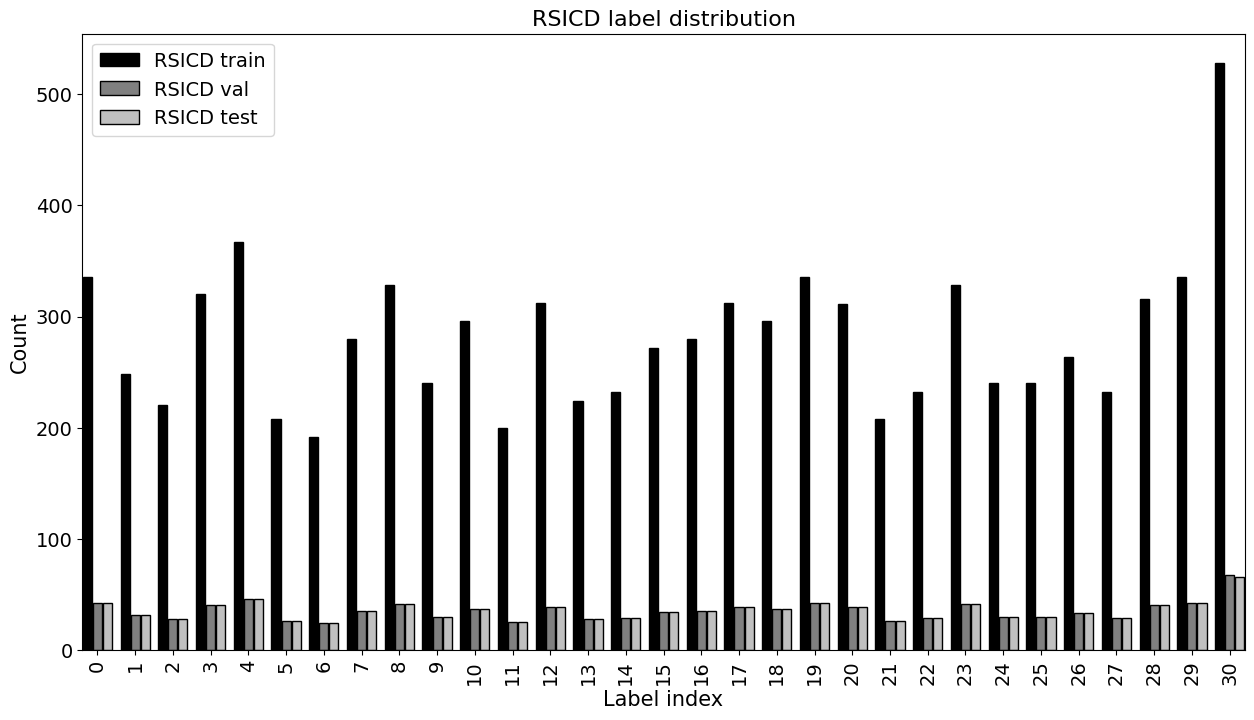

Sum train: 8734
Sum val: 1094
Sum test: 1093


In [9]:
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data to plot. Keys = the names of the data, items = a list of the values.

        Example: data = {"x":[1,2,3], "y":[1,2,3], "z":[1,2,3]}

    colors : array-like, optional, default: None
        A list of colors to use for the bars. If None, the colors are the standard matplotlib color cyle. 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars will touch each other 
        within a group, values less than 1 will make these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []
    heights_left_bar = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x+x_offset, y, width=bar_width*single_width, color=colors[i % len(colors)], edgecolor = "black")
            height = bar[0].get_height()
            width = bar[0].get_width()
            loc = bar[0].get_x()
            
            if i % 3 == 0:
                heights_left_bar.append(height)

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper left')
        
        
data = {
    # 'RSICD total': all_counts,
    'RSICD train': rsicd_train_counts, #/rsicd_all_counts*100, 
    'RSICD val': rsicd_val_counts, #/rsicd_all_counts*100,
    'RSICD test': rsicd_test_counts, #/rsicd_all_counts*100,
}

# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(15, 8))
font_size = 14

# Plot the bars and significances
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'gray', 'silver', 'white'], font_size = font_size )


# Add text to the plot
plt.title('RSICD label distribution', fontsize = font_size + 2)
plt.xticks(range(rsicd_train_labels.shape[0]), rsicd_train_labels, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('Count', fontsize = font_size+1)
plt.xlabel('Label index', fontsize = font_size+1)
plt.xlim(min(rsicd_train_labels)-0.4, max(rsicd_train_labels)+0.4)

# Store the plot as a .png
# plt.savefig('./results/FPs_distance_property.png', bbox_inches = 'tight')
plt.show()

print('Sum train:', np.sum(rsicd_train_counts))
print('Sum val:', np.sum(rsicd_val_counts))
print('Sum test:', np.sum(rsicd_test_counts))

In [10]:
# split_classes = []
# for d in data:
#     split_classes.append(path2class[d['filename']])
# Counter(split_classes)

In [11]:
path = './data/UCMerced_LandUse/Images'
num_images_in_folders = []
ucm_cls_paths = []
ucm_cls_images = []
folders = []
for folder in os.listdir(path):
    folders.append(folder)
    contents = os.listdir(os.path.join(path, folder))
    num_images_in_folders.append(len(contents))
    for img_name in contents:
        img = Image.open(os.path.join(path, folder, img_name))
        img = np.array(img.resize((256,256)))
        ucm_cls_images.append(img)
        ucm_cls_paths.append(folder)
print(num_images_in_folders)
ucm_cls_images = np.stack(ucm_cls_images)
print(ucm_cls_images.shape)
print(folders)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
(2100, 256, 256, 3)
['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']


In [12]:
path = './data/UCM/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')

splits = [train, val, test]
for split in splits:
    print(len(split)/len(all))

0.8
0.1
0.1


In [13]:
ucm_images_path = './data/UCM/images'
ucm_images = []
ucm_paths = []
for img_name in sorted(os.listdir(ucm_images_path), key = lambda x: int(x.split('.')[0])):
    img = Image.open(os.path.join(ucm_images_path, img_name))
    img_np = np.array(img)
    ucm_images.append(img_np)
    ucm_paths.append(img_name)
ucm_images = np.stack(ucm_images)
print(ucm_images.shape)

(2100, 256, 256, 3)


In [14]:
ucm_to_cls_mappings = dict(zip(ucm_paths, ucm_cls_paths))
write_json('./data/UCM/caption_to_cls_mapping.json', ucm_to_cls_mappings)

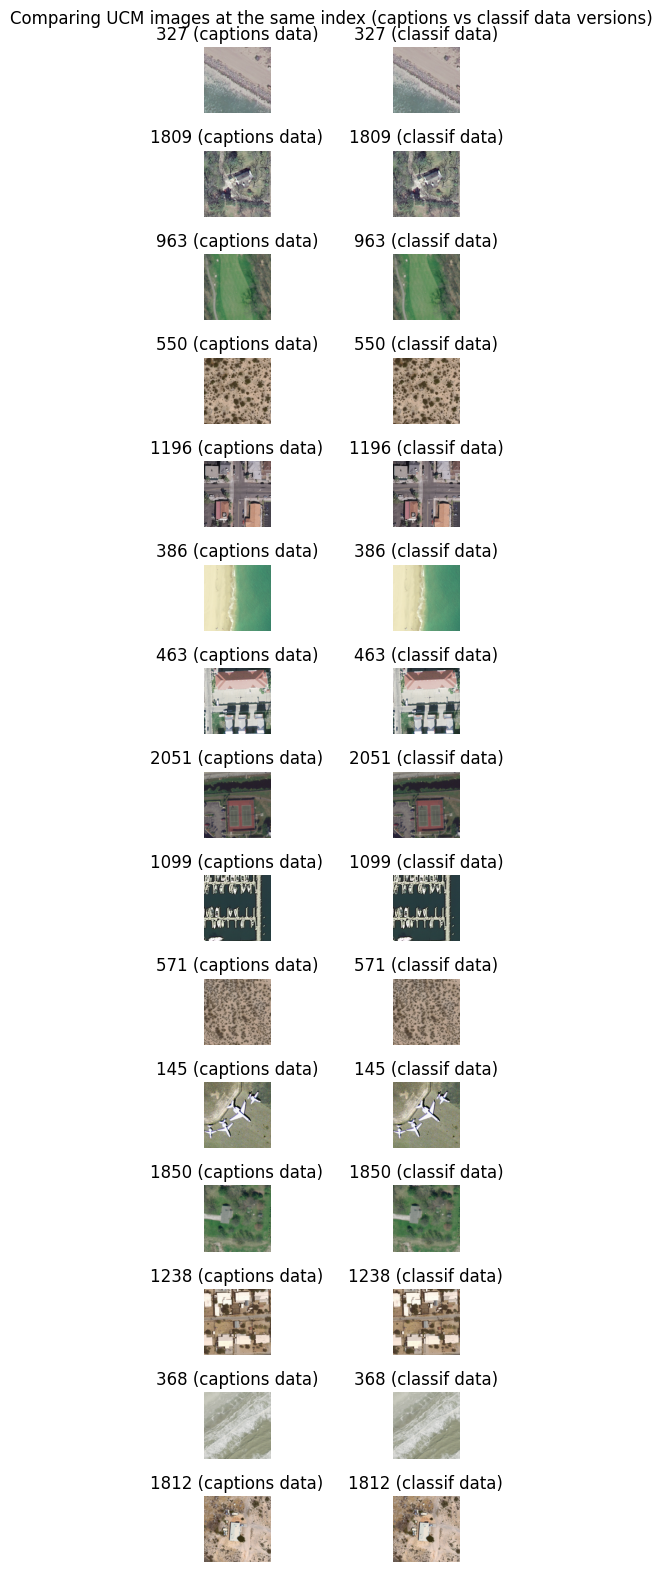

In [15]:
num_comparisons = 15
fig, ax = plt.subplots(num_comparisons, 2, figsize=(5,16))
for i, idx in enumerate(np.random.choice(np.arange(ucm_images.shape[0]), size = num_comparisons, replace = False)):
    ax[i][0].imshow(ucm_images[idx])
    ax[i][1].imshow(ucm_cls_images[idx])
    ax[i][0].set_title('{} (captions data)'.format(idx))
    ax[i][1].set_title('{} (classif data)'.format(idx))
    ax[i][0].axis('off')
    ax[i][1].axis('off')
plt.suptitle('Comparing UCM images at the same index (captions vs classif data versions)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
train_classes = []
for p in train:
    train_classes.append(ucm_to_cls_mappings[p])
Counter(train_classes)

Counter({'airplane': 81,
         'harbor': 81,
         'intersection': 81,
         'agricultural': 80,
         'baseballdiamond': 80,
         'beach': 80,
         'buildings': 80,
         'chaparral': 80,
         'forest': 80,
         'freeway': 80,
         'golfcourse': 80,
         'mediumresidential': 80,
         'mobilehomepark': 80,
         'overpass': 80,
         'parkinglot': 80,
         'river': 80,
         'runway': 80,
         'sparseresidential': 80,
         'storagetanks': 80,
         'tenniscourt': 80,
         'denseresidential': 77})

In [17]:
val_classes = []
for p in val:
    val_classes.append(ucm_to_cls_mappings[p])
Counter(val_classes)

Counter({'denseresidential': 13,
         'agricultural': 10,
         'baseballdiamond': 10,
         'beach': 10,
         'buildings': 10,
         'chaparral': 10,
         'forest': 10,
         'freeway': 10,
         'golfcourse': 10,
         'mediumresidential': 10,
         'mobilehomepark': 10,
         'overpass': 10,
         'parkinglot': 10,
         'river': 10,
         'runway': 10,
         'sparseresidential': 10,
         'storagetanks': 10,
         'tenniscourt': 10,
         'airplane': 9,
         'harbor': 9,
         'intersection': 9})

In [18]:
test_classes = []
for p in test:
    test_classes.append(ucm_to_cls_mappings[p])
Counter(test_classes)

Counter({'agricultural': 10,
         'airplane': 10,
         'baseballdiamond': 10,
         'beach': 10,
         'buildings': 10,
         'chaparral': 10,
         'denseresidential': 10,
         'forest': 10,
         'freeway': 10,
         'golfcourse': 10,
         'harbor': 10,
         'intersection': 10,
         'mediumresidential': 10,
         'mobilehomepark': 10,
         'overpass': 10,
         'parkinglot': 10,
         'river': 10,
         'runway': 10,
         'sparseresidential': 10,
         'storagetanks': 10,
         'tenniscourt': 10})

In [19]:
path = './data/sydney_captions/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')
splits = [train, val, test]
for split in splits:
    print(len(split))
    print(round(len(split)/len(all),2))
# read_json(path)
# print(os.listdir(path+'/images'))

497
0.81
58
0.09
58
0.09


In [20]:
root = './data/UCM/'

X = list(ucm_to_cls_mappings.keys())
y = list(ucm_to_cls_mappings.values())
N = len(X)
UCM_data = load_captions(os.path.join(root, 'dataset.json'), ['train', 'val'])
X_trainval = []
y_trainval = []
for i, x in enumerate(X):
    if x in UCM_data:
        X_trainval.append(x)
        y_trainval.append(y[i])
store_k_folds(X, y, N, root, print_indices = True)

Fold 0:
  Train: ratio=88.86
  Val:  ratio=11.14
  Train: index=['1.tif' '2.tif' '3.tif' ... '2098.tif' '2099.tif' '2100.tif']
  Val:  index=['9.tif' '10.tif' '16.tif' '29.tif' '31.tif' '36.tif' '43.tif' '52.tif'
 '55.tif' '57.tif' '85.tif' '88.tif' '126.tif' '142.tif' '149.tif'
 '152.tif' '166.tif' '172.tif' '176.tif' '177.tif' '192.tif' '195.tif'
 '199.tif' '206.tif' '226.tif' '227.tif' '228.tif' '240.tif' '243.tif'
 '249.tif' '275.tif' '280.tif' '296.tif' '298.tif' '302.tif' '309.tif'
 '311.tif' '325.tif' '330.tif' '340.tif' '348.tif' '363.tif' '373.tif'
 '381.tif' '392.tif' '403.tif' '411.tif' '417.tif' '422.tif' '427.tif'
 '439.tif' '476.tif' '478.tif' '495.tif' '497.tif' '500.tif' '503.tif'
 '504.tif' '520.tif' '529.tif' '532.tif' '543.tif' '550.tif' '580.tif'
 '588.tif' '592.tif' '597.tif' '608.tif' '611.tif' '622.tif' '623.tif'
 '635.tif' '638.tif' '656.tif' '668.tif' '675.tif' '676.tif' '695.tif'
 '703.tif' '706.tif' '722.tif' '740.tif' '761.tif' '768.tif' '777.tif'
 '780.tif'

In [21]:
# I want to probably get the dict['items'] values for each folder and then take the images from there.
working_datasets = [] #['RSICD', 'UCM', 'Sydney', 'Fashion200k', 'SciCap', 'RSICD-CLS', 'UCM-CLS', 'Fashion200k-CLS', 'WHU-RS19', 'RSSCN7', 
                    #'AID', 'RESISC45', 'Simpsons-Images', 'Polyvore', 'Polyvore-CLS', 'FashionGen', 'FashionGen-CLS']
# get_custom_data(args, data, preprocess_fn, is_train, cls, subclass, **data_kwargs):
for dataset in working_datasets:
    print(dataset)
    cls = 'CLS' in dataset
    # CLS version of most datasets just uses the non-CLS dataloader, but adds cls = True as argument
    if dataset != 'UCM-CLS': # Exception: UCM-CLS is a different dataloader altogether than UCM!
        dataset = dataset.replace('-CLS', '')
    get_custom_data(None, data = dataset, preprocess_fn = None, is_train = True,)